In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from torch import nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.flat = nn.Flatten()
        self.fc1  = nn.Linear(input_size, 50)
        self.fc2  = nn.Linear(50, num_classes)
            
    def forward(self, x):
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [4]:
input_size = 28*28
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 5
print_offset = 250

model = NN(input_size, num_classes).to(device=device)
print("Model Architecture: \n", model)

Model Architecture: 
 NN(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [5]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset  = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)

In [6]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(938, 157)

torch.Size([64, 1, 28, 28]) torch.Size([64])


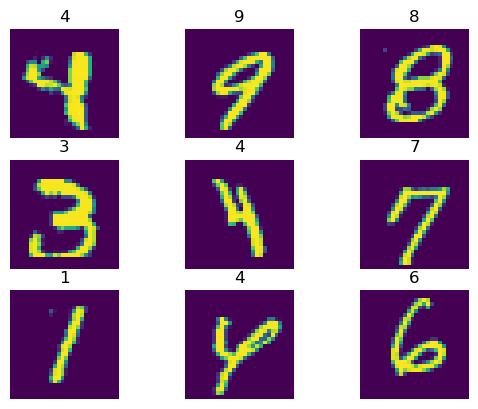

In [7]:
# Lets print some images from training dataset
import matplotlib.pyplot as plt
samples = iter(train_loader)
images, lables = samples._next_data()
print(images.shape, lables.shape)

for i in range (9): # Plot first 9 images from the batch
    plt.subplot(3,3,i+1)
    plt.imshow(images[i][0])
    plt.title(lables.numpy()[i])
    plt.axis('off')
plt.show()

In [8]:
def accuracy(y_pred, y_true):
    y_pred = y_pred.to(device=device)
    y_true = y_true.to(device=device)
    #_, y_pred_idx = y_pred.max(1)   # Or Can be written as below line
    _, y_pred_idx = torch.max(y_pred, dim = 1) 
    return y_pred_idx.eq(y_true).sum() / len(y_true), y_pred_idx

In [9]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def confusion_classification(y_true, y_pred, title, normalize=False, cmap=plt.cm.Blues):
    classes = [0,1,2,3,4,5,6,7,8,9]
    # Classification Report
    cr = classification_report(y_true, y_pred)
    print(title + " Classification Report \n", cr)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + " Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch:1/5, train_loss:0.4168, train_accu:88.90%, test_loss:0.2597, test_accu:92.41%
epoch:2/5, train_loss:0.2199, train_accu:93.85%, test_loss:0.1838, test_accu:94.59%
epoch:3/5, train_loss:0.1655, train_accu:95.18%, test_loss:0.1486, test_accu:95.51%
epoch:4/5, train_loss:0.1325, train_accu:96.19%, test_loss:0.1324, test_accu:96.14%
epoch:5/5, train_loss:0.1125, train_accu:96.67%, test_loss:0.1171, test_accu:96.52%
Training Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5923
           1       0.98      0.98      0.98      6742
           2       0.97      0.97      0.97      5958
           3       0.96      0.95      0.95      6131
           4       0.96      0.97      0.97      5842
           5       0.96      0.96      0.96      5421
           6       0.98      0.98      0.98      5918
           7       0.97      0.97      0.97      6265
           8       0.96      0.95      0.95      5851
      

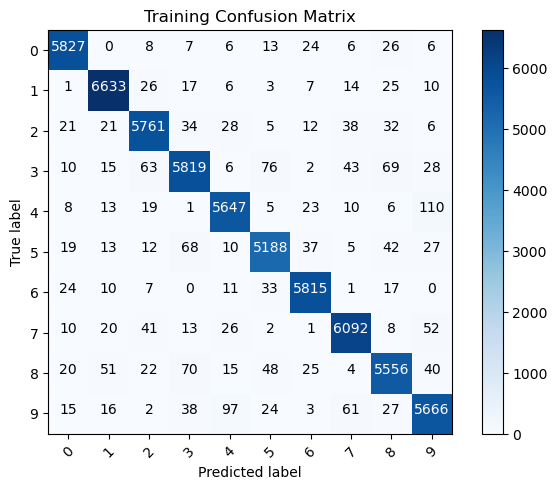

------------------------------------------------------------------------------------------
Testing Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.97      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.95      0.97      0.96       892
           6       0.96      0.98      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.93      0.95       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000



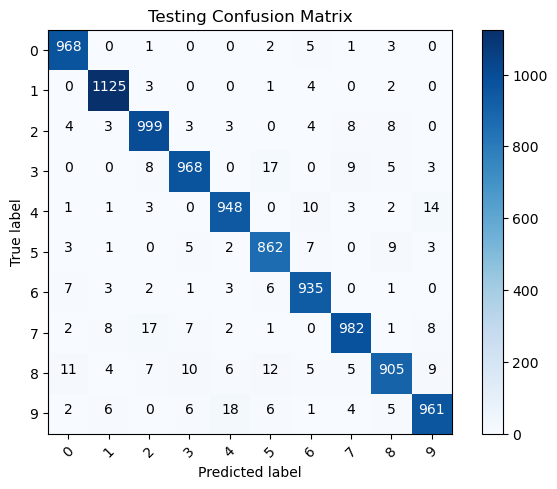

In [11]:
# Train and Validation
train_true, train_pred, test_true, test_pred = [],[],[],[] # Define Empty lists for matrix calculate

for epoch in range(1, num_epochs+1):
    
    train_loss = train_accuracy = test_loss = test_accuracy = 0
    
    for data, target in train_loader:
        data = data.to(device=device)
        target = target.to(device=device)
        
        # Forward pass
        pred = model(data)
        loss_train = criterion(pred, target)
        accu_train, pred_train  = accuracy(pred, target)

        train_loss += loss_train
        train_accuracy += accu_train
        
        # Backward and Optimizer
        # zero the parameters grad
        optimizer.zero_grad() 
        loss_train.backward()
        optimizer.step()

        if epoch == num_epochs:
            train_true.extend(target.cpu().numpy())
            train_pred.extend(pred_train.cpu().numpy())

    with torch.no_grad():
        model.eval()
        
        for data_t, target_t in test_loader:
            data_t = data_t.to(device=device)
            target_t = target_t.to(device = device)
            
            pred_t = model(data_t)
            
            loss_test = criterion(pred_t, target_t)
            accu_test, pred_test = accuracy(pred_t, target_t)
            
            test_loss += loss_test
            test_accuracy += accu_test

            if epoch == num_epochs:
                test_true.extend(target_t.cpu().numpy())
                test_pred.extend(pred_test.cpu().numpy())

    print(f"epoch:{epoch}/{num_epochs}, train_loss:{train_loss / len(train_loader):.4f}, train_accu:{(train_accuracy / len(train_loader))*100:.2f}%, test_loss:{test_loss / len(test_loader):.4}, test_accu:{(test_accuracy / len(test_loader))*100:.2f}%")

# Cal cm and cr:
confusion_classification(train_true, train_pred, 'Training')
print("------------------------------------------------------------------------------------------")
confusion_classification(test_true, test_pred, 'Testing')

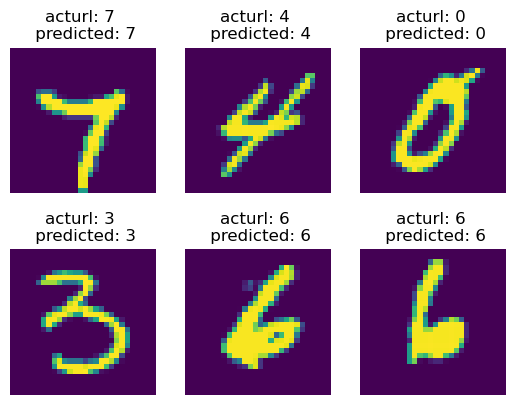

In [12]:
# Lets print some prediction from Test dataset
images, lables = next(iter(train_loader))
images = images.to(device)

output = model(images)
output = output.to('cpu')
_, pred = torch.max(output, dim = 1)

for i in range (6): # Plot first 6 images from the batch
    plt.subplot(2,3,i+1)
    plt.imshow(images.cpu()[i][0])
    plt.title(f"acturl: {lables.numpy()[i]} \n predicted: {pred.cpu().numpy()[i]}")
    plt.axis('off')
plt.show()

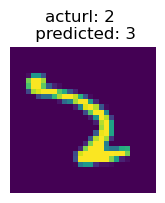

In [13]:
# Lets print some incorrect prediction within the batch
x = 0
for j in range (lables.shape[0]):
    if lables.numpy()[j] != pred.cpu().numpy()[j] and x <= 6:
        x += 1
        plt.subplot(2,3,x)
        plt.imshow(images.cpu()[j][0])
        plt.title(f"acturl: {lables.numpy()[j]} \n predicted: {pred.cpu().numpy()[j]}")
        plt.axis('off')